In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
plt.style.use('fivethirtyeight')

In [14]:
# import data set
data_clean = pd.read_csv('data_clean.csv',index_col=0, parse_dates=True)
data_clean['date'] = pd.to_datetime(data_clean['date'])
data_clean = data_clean[data_clean['date'] <= pd.Timestamp('2022-05-14')]
split_date = '2022-05-01'
train = data_clean[data_clean['date'] < split_date]
test = data_clean[data_clean['date'] >= split_date]

# prepare variables
train.set_index('date', inplace=True)
test.set_index('date', inplace=True)
train.rename(columns={'new_cases': 'y'}, inplace=True)
test.rename(columns={'new_cases': 'y'}, inplace=True)
print(train.shape)
print(test.shape)

(7710, 30)
(140, 30)


/var/folders/n4/3g40sf9n163fj3t1fbrvlns40000gn/T/ipykernel_81922/3600536415.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_clean = pd.read_csv('data_clean.csv',index_col=0, parse_dates=True)
/var/folders/n4/3g40sf9n163fj3t1fbrvlns40000gn/T/ipykernel_81922/3600536415.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.rename(columns={'new_cases': 'y'}, inplace=True)
/var/folders/n4/3g40sf9n163fj3t1fbrvlns40000gn/T/ipykernel_81922/3600536415.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

In [15]:
# impute outliers in target varible 
from sklearn.preprocessing import RobustScaler
scalers = {}
for location, train_country_data in train.groupby('location'):
    scaler = RobustScaler()
    scaler.fit(train_country_data[['y']])
    train.loc[train['location'] == location, 'y_scaled'] = scaler.transform(train_country_data[['y']])
    # apply to test
    test_country_data = test[test['location'] == location]
    test.loc[test['location'] == location, 'y_scaled'] = scaler.transform(test_country_data[['y']])
    scalers[location] = scaler

/var/folders/n4/3g40sf9n163fj3t1fbrvlns40000gn/T/ipykernel_81922/1585008228.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[train['location'] == location, 'y_scaled'] = scaler.transform(train_country_data[['y']])
/var/folders/n4/3g40sf9n163fj3t1fbrvlns40000gn/T/ipykernel_81922/1585008228.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[test['location'] == location, 'y_scaled'] = scaler.transform(test_country_data[['y']])


In [16]:
# set x_train
x_train = train.drop(columns=['y','y_scaled'])
y_train = train['y']
y_train_scaled = train['y_scaled']
x_test = test.drop(columns=['y','y_scaled'])
y_test = test['y']
y_test_scaled = test['y_scaled']
x_train.columns

Index(['location', 'new_deaths', 'reproduction_rate', 'new_tests',
       'stringency_index', 'population_density', 'aged_70_older',
       'diabetes_prevalence', 'female_smokers', 'life_expectancy',
       'human_development_index', 'population', 'holidays', 'season',
       'day_of_week', 'weekend', 'month', 'year', 'quarter', 'dayofyear',
       'dayofmonth', 'weekofyear', 'new_cases_lag1', 'new_cases_lag7',
       'new_cases_lag8', 'new_cases_roll_mean7', 'new_cases_roll_std7',
       'new_cases_roll_mean14', 'new_cases_roll_std14'],
      dtype='object')

In [17]:
# encode location since my xgb doesn't support enable_categorical
x_train = pd.get_dummies(x_train, columns=['location'])
x_test = pd.get_dummies(x_test, columns=['location'])

# encode holidays and season
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
x_train['holidays'] = le.fit_transform(x_train['holidays'])
x_test['holidays'] = le.transform(x_test['holidays'])
x_train['season'] = le.fit_transform(x_train['season'])
x_test['season'] = le.transform(x_test['season'])
x_train['season'].head()

date
2020-03-21    1
2020-03-22    1
2020-03-23    1
2020-03-24    1
2020-03-25    1
Name: season, dtype: int64

## Model Development

### Italy

Train RMSE: 494.60105488293794
Test RMSE: 2643.6873577030237


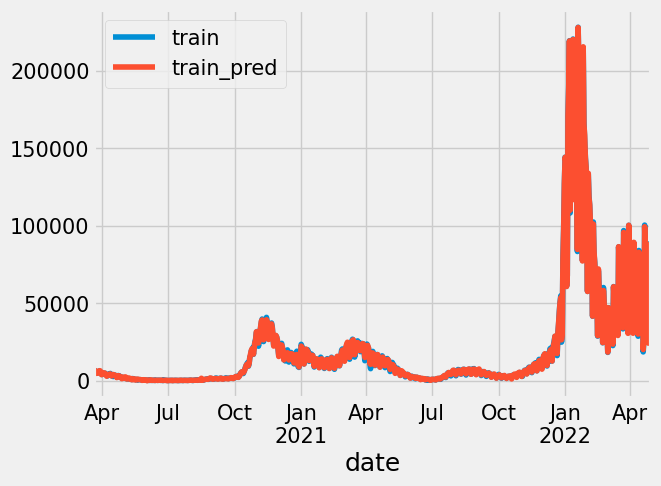

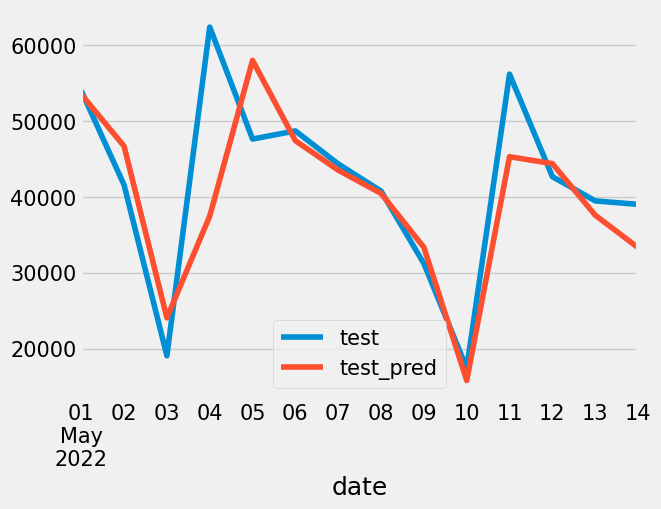

In [20]:
model2 = xgb.XGBRegressor(enable_categorical = True,
                          learning_rate=0.3, 
                          max_depth=3, 
                          n_estimators=500, 
                         subsample = 1, 
                         colsample_bytree = 0.9,                          
                          n_jobs=-1, 
                          random_state=0)
model2.fit(x_train, y_train)

train_pred=pd.DataFrame((model2.predict(x_train)), columns=['yhat'], index=train.index)
train_combined = pd.concat([x_train,y_train,train_pred['yhat']], axis=1)
subset_italy = train_combined[train_combined['location_Italy'] == 1]
pd.concat([subset_italy['y'], subset_italy['yhat']], axis=1).plot()
plt.legend(['train', 'train_pred'])

test_pred=pd.DataFrame((model2.predict(x_test)), columns=['yhat'], index=test.index)
test_combined = pd.concat([x_test,y_test,test_pred['yhat']], axis=1)
subset_italy = test_combined[test_combined['location_Italy'] == 1]
pd.concat([subset_italy['y'], subset_italy['yhat']], axis=1).plot()
plt.legend(['test', 'test_pred'])

train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')



## Grid Search

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb

In [26]:
#K-fold cross validation to find optimal parameters for XGBoost
import time
from sklearn.model_selection import KFold, RandomizedSearchCV

# Assuming x_train and y_train are already defined and properly formatted for multivariate analysis
start_time = time.time()

param_grid = {'max_depth': [3, 5, 7, 9],
              'learning_rate': [0.05, 0.1, 0.3],
              'reg_lambda': [0, 1, 10],
            #   'n_estimators': [100, 500, 1000],
              'gamma': [0, 10, 100],
              'subsample': [0.8, 0.9, 1.0],
              'colsample_bytree': [0.5, 0.75, 1.0]}

cv = KFold(n_splits=5, shuffle=True, random_state=1)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=1, n_estimators=200),
                                    param_distributions=param_grid, n_iter=200,
                                    verbose=1, n_jobs=-1, cv=cv,
                                    scoring='neg_root_mean_squared_error') # Setting RMSE as the evaluation metric
optimal_params.fit(x_train, y_train)

print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross-validation RMSE =", optimal_params.best_score_)
print("Time taken = ", round((time.time() - start_time) / 60), " minutes")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Optimal parameter values = {'subsample': 1.0, 'reg_lambda': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 10, 'colsample_bytree': 0.75}
Optimal cross-validation RMSE = -3298.6771100605415
Time taken =  1  minutes


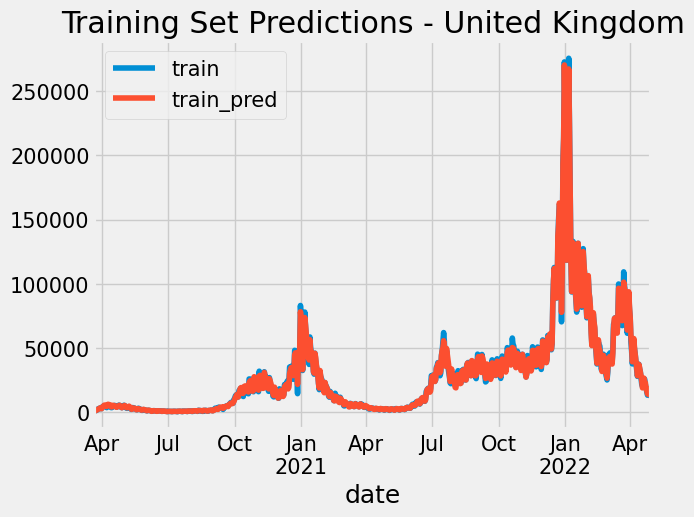

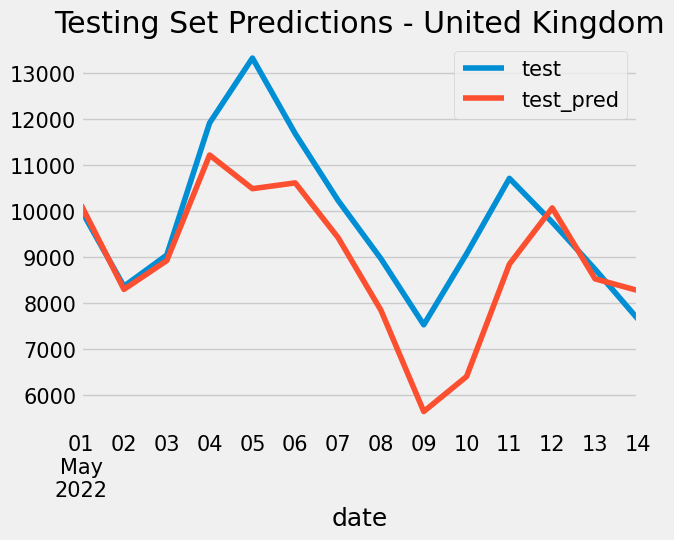

United Kingdom - Train RMSE: 1630.858565195188
United Kingdom - Test RMSE: 1371.310612121014


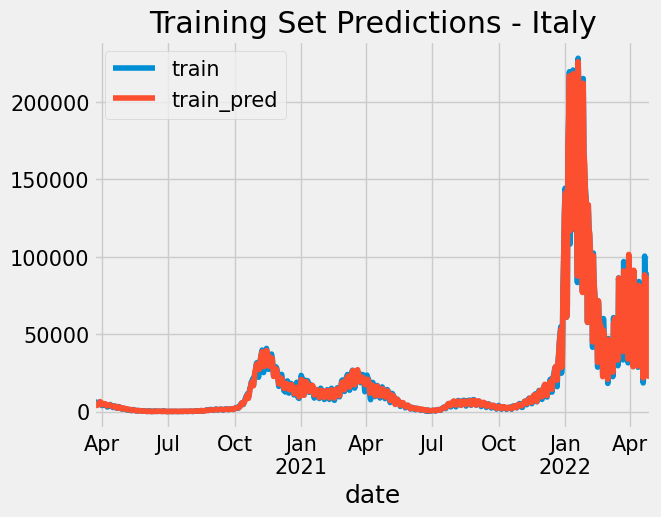

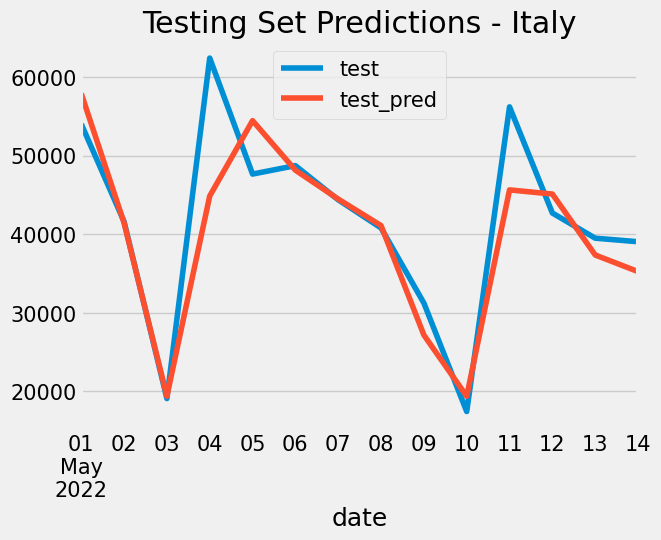

Italy - Train RMSE: 1593.14720889727
Italy - Test RMSE: 6136.034171814835


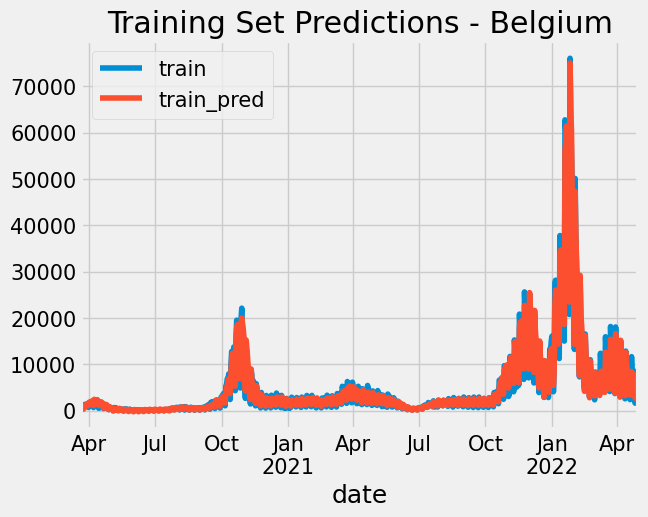

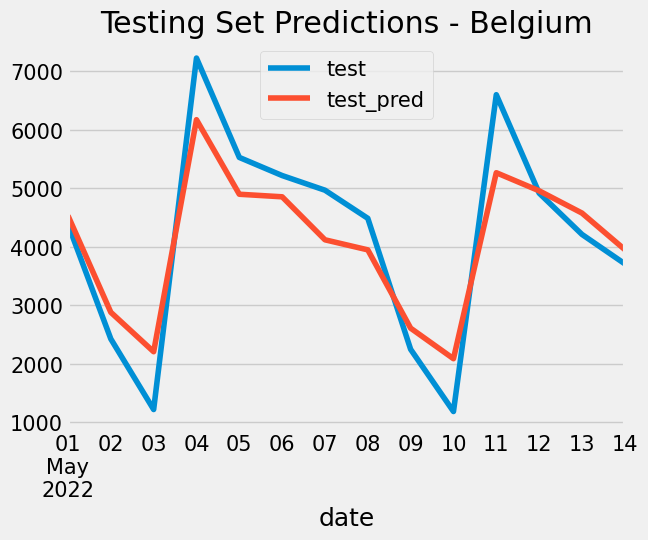

Belgium - Train RMSE: 1008.0807547927772
Belgium - Test RMSE: 696.0077547108326


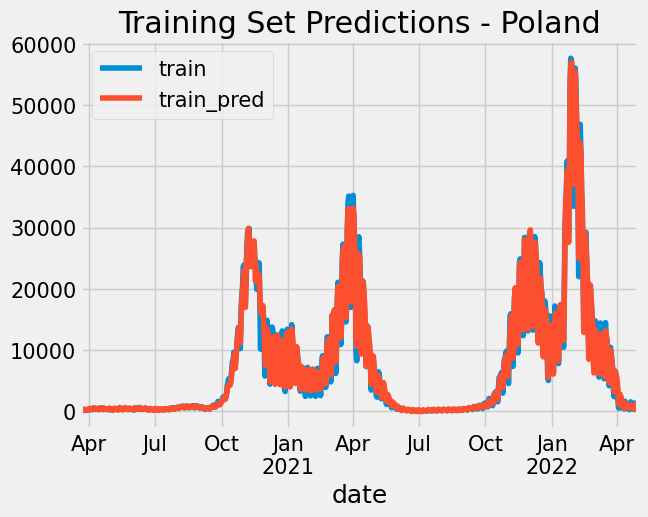

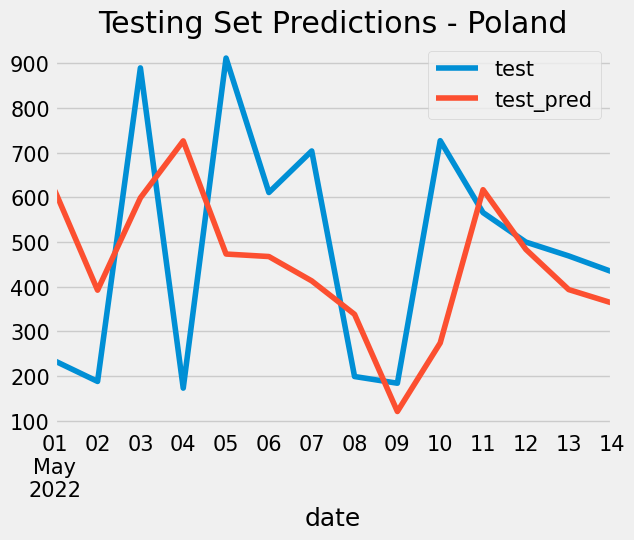

Poland - Train RMSE: 937.3862260095977
Poland - Test RMSE: 282.60691949154335


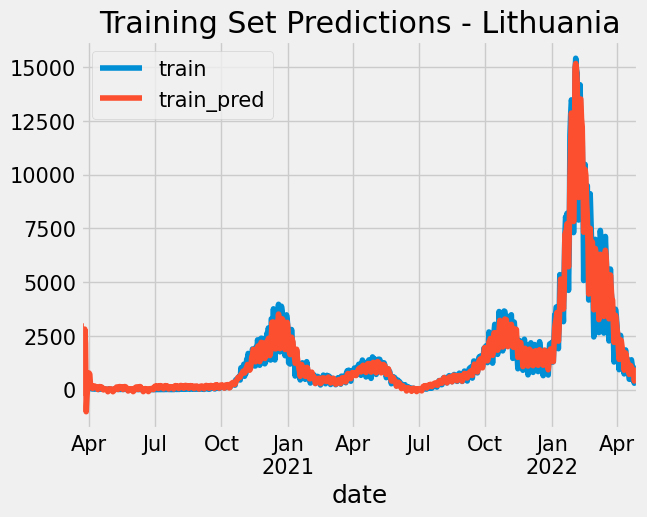

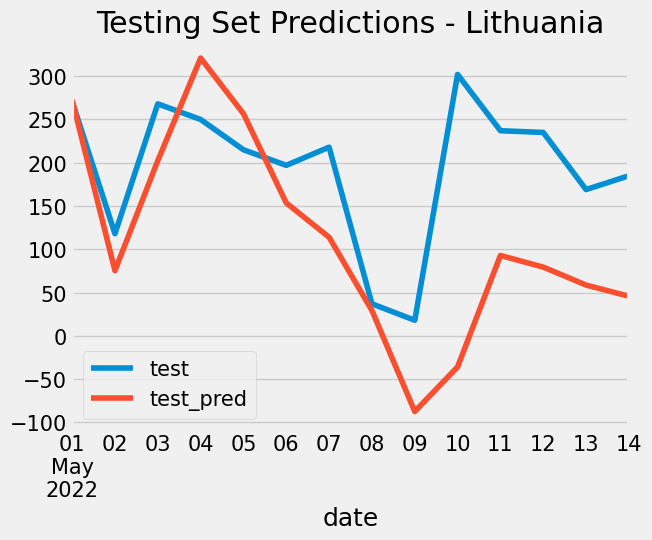

Lithuania - Train RMSE: 382.5634416724758
Lithuania - Test RMSE: 127.46554665634238


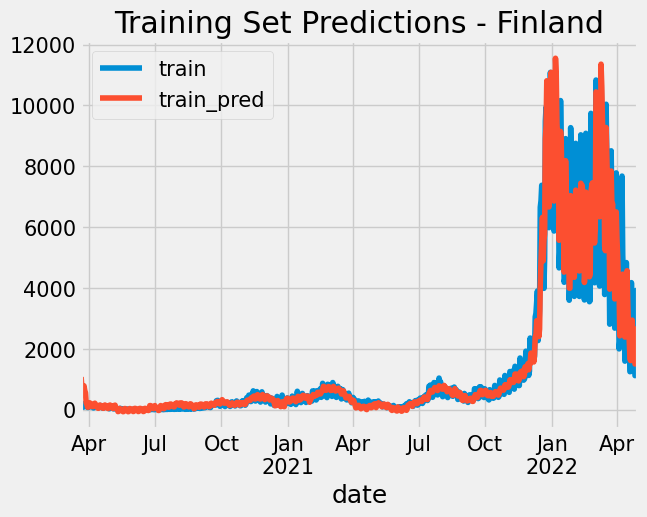

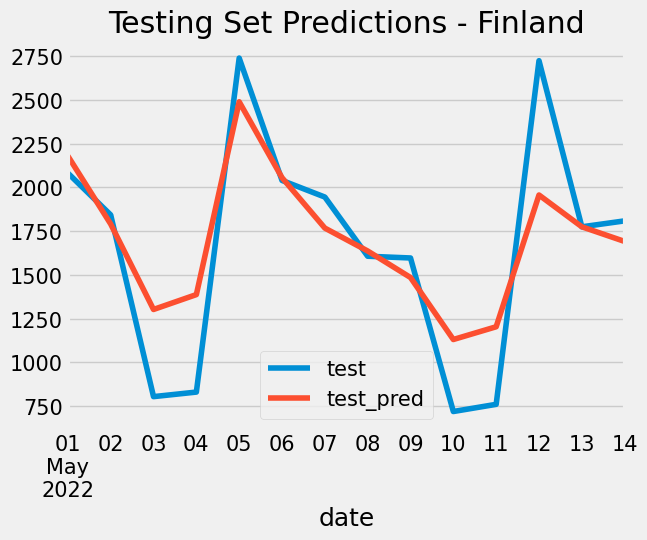

Finland - Train RMSE: 463.93676196436536
Finland - Test RMSE: 342.85249360407516


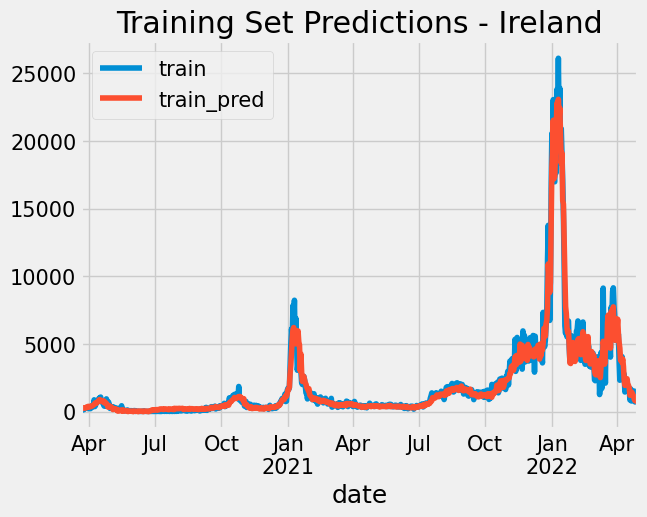

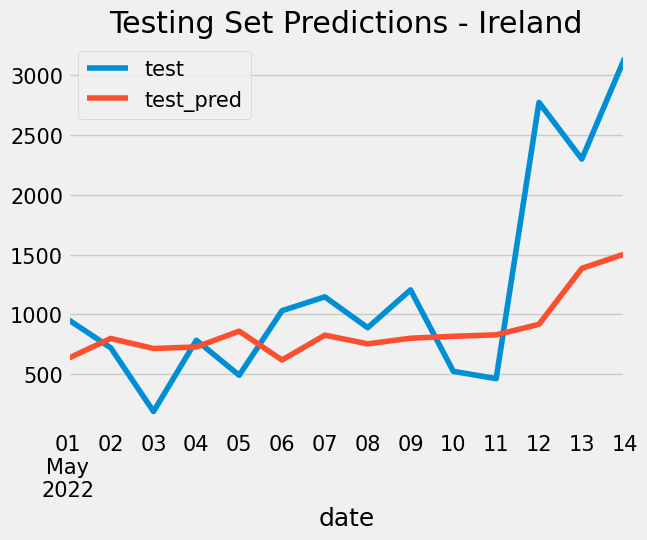

Ireland - Train RMSE: 599.6967121359994
Ireland - Test RMSE: 763.8225653958315


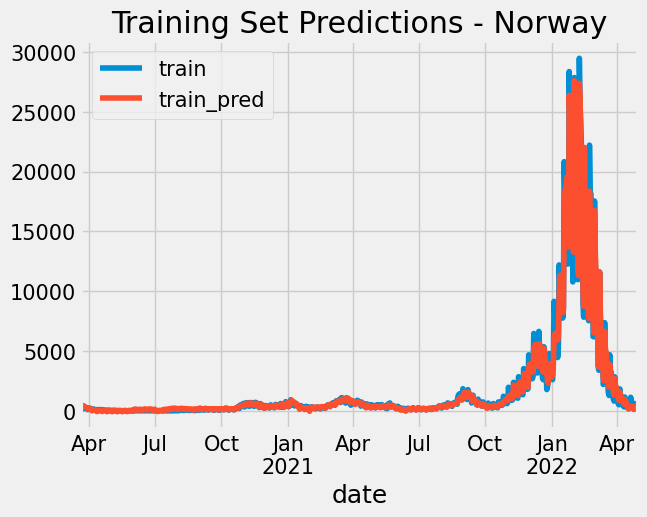

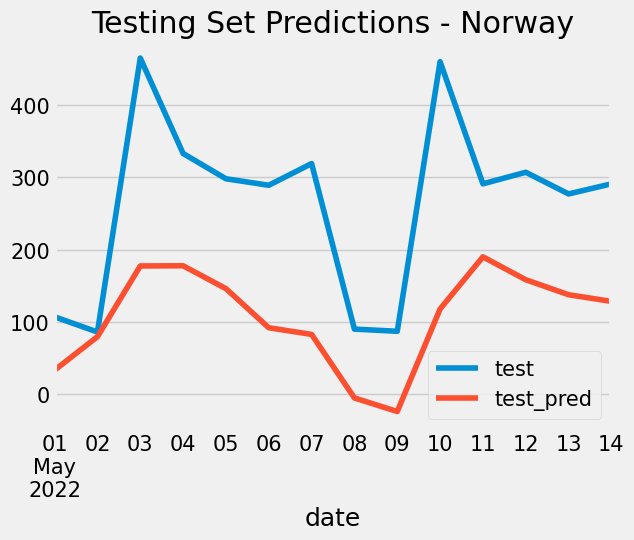

Norway - Train RMSE: 462.1378191634382
Norway - Test RMSE: 178.6531867837828


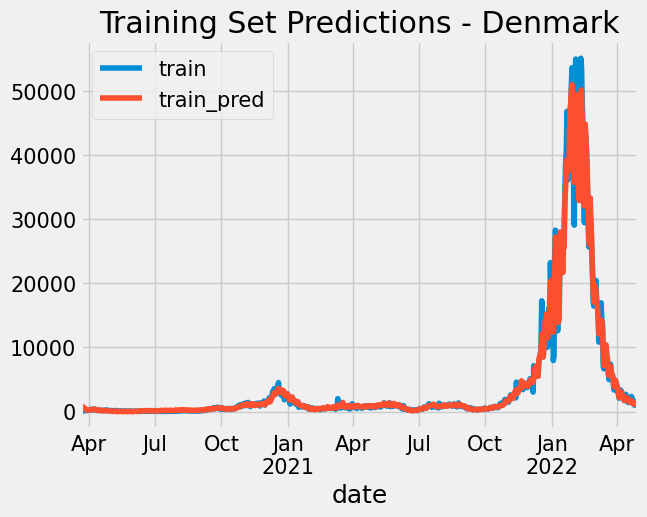

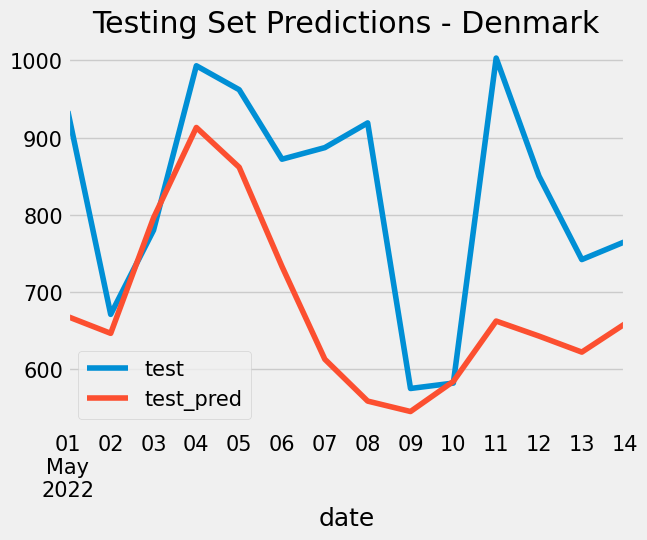

Denmark - Train RMSE: 967.7902641007275
Denmark - Test RMSE: 188.59453669564738


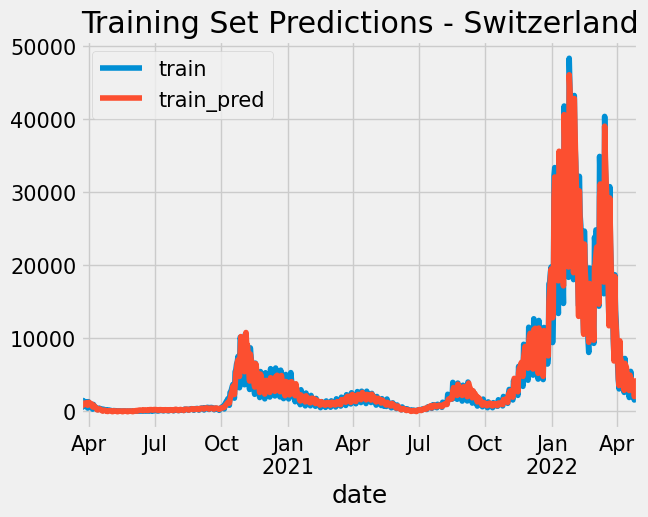

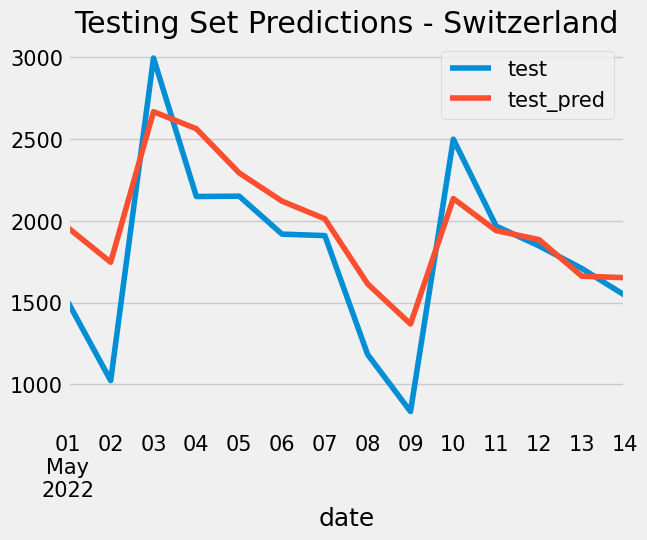

Switzerland - Train RMSE: 750.5517661743025
Switzerland - Test RMSE: 348.3339983837955
                 train_rmse    test_rmse
United Kingdom  1630.858565  1371.310612
Italy           1593.147209  6136.034172
Belgium         1008.080755   696.007755
Poland           937.386226   282.606919
Lithuania        382.563442   127.465547
Finland          463.936762   342.852494
Ireland          599.696712   763.822565
Norway           462.137819   178.653187
Denmark          967.790264   188.594537
Switzerland      750.551766   348.333998


In [27]:
model3 = xgb.XGBRegressor(enable_categorical = True,
                          subsample = 1,
                          reg_lambda = 1,
                          max_depth = 5, 
                          learning_rate=0.1, 
                          gamma = 10,
                          colsample_bytree = 0.75,
                          n_jobs=-1, 
                          random_state=0)
model3.fit(x_train, y_train)

countries = ['United Kingdom', 'Italy', 'Belgium', 'Poland','Lithuania','Finland', 'Ireland', 'Norway', 'Denmark','Switzerland']
rmse_results = {}

for country in countries:
    location_column = f'location_{country}'

    # train set preds
    train_pred = pd.DataFrame(model3.predict(x_train), columns=['yhat'], index=train.index)
    train_combined = pd.concat([x_train, y_train, train_pred['yhat']], axis=1)
    subset_country_train = train_combined[train_combined[location_column] == 1]

    subset_country_train[['y', 'yhat']].plot()
    plt.title(f'Training Set Predictions - {country}')
    plt.legend(['train', 'train_pred'])
    plt.show()

    # test set preds
    test_pred = pd.DataFrame(model3.predict(x_test), columns=['yhat'], index=test.index)
    test_combined = pd.concat([x_test, y_test, test_pred['yhat']], axis=1)
    subset_country_test = test_combined[test_combined[location_column] == 1]

    subset_country_test[['y', 'yhat']].plot()
    plt.title(f'Testing Set Predictions - {country}')
    plt.legend(['test', 'test_pred'])
    plt.show()

    # Calculate and print RMSE for training and testing sets
    train_rmse = sqrt(mean_squared_error(subset_country_train['y'], subset_country_train['yhat']))
    test_rmse = sqrt(mean_squared_error(subset_country_test['y'], subset_country_test['yhat']))
    rmse_results[country] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}
    
    print(f'{country} - Train RMSE: {train_rmse}')
    print(f'{country} - Test RMSE: {test_rmse}')
rmse_df = pd.DataFrame(rmse_results).T
print(rmse_df)


## Early Stopping

/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


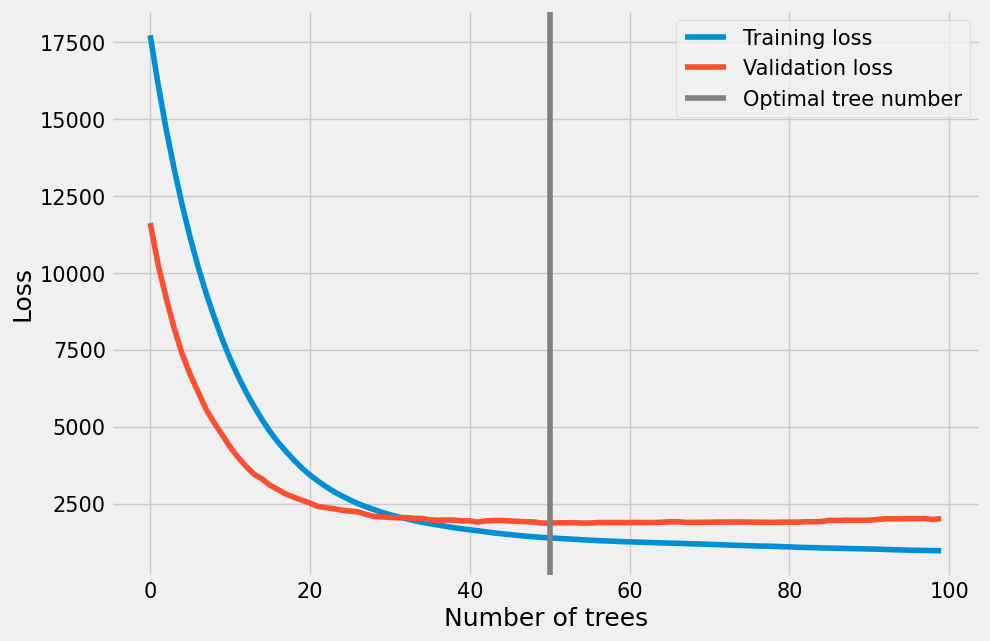

In [28]:
model4 = xgb.XGBRegressor(enable_categorical = True,
                          subsample = 1,
                          reg_lambda = 1,
                          max_depth = 5, 
                          learning_rate=0.1, 
                          gamma = 10,
                          colsample_bytree = 0.75,
                          n_jobs=-1, 
                          random_state=0)
model4.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)], 
       verbose=False, early_stopping_rounds = 50)

results = model4.evals_result()
plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(model4.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [29]:
model4.best_iteration

50

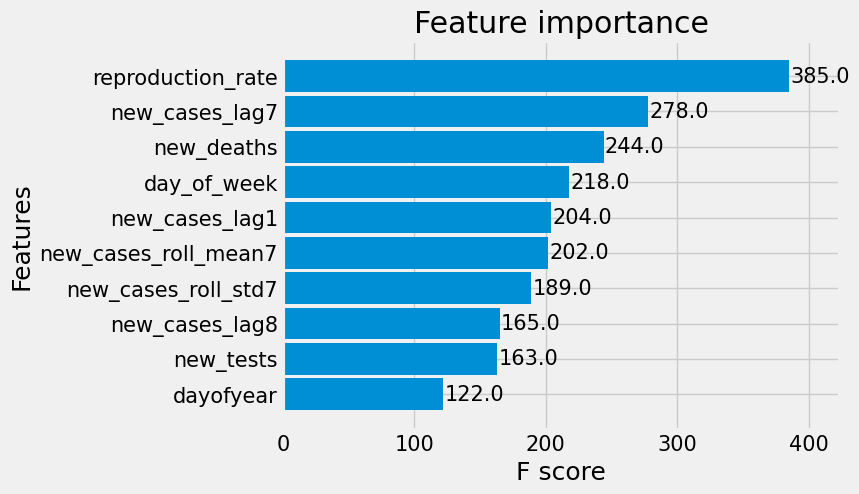

In [30]:
_ = plot_importance(model4, height=0.9 ,max_num_features = 10)

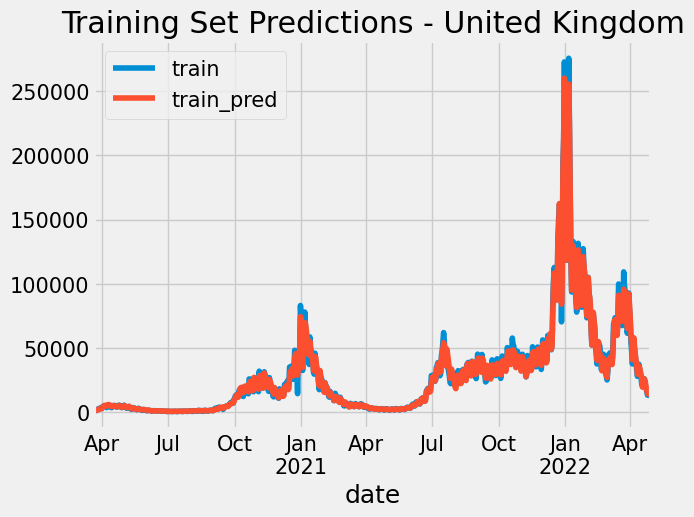

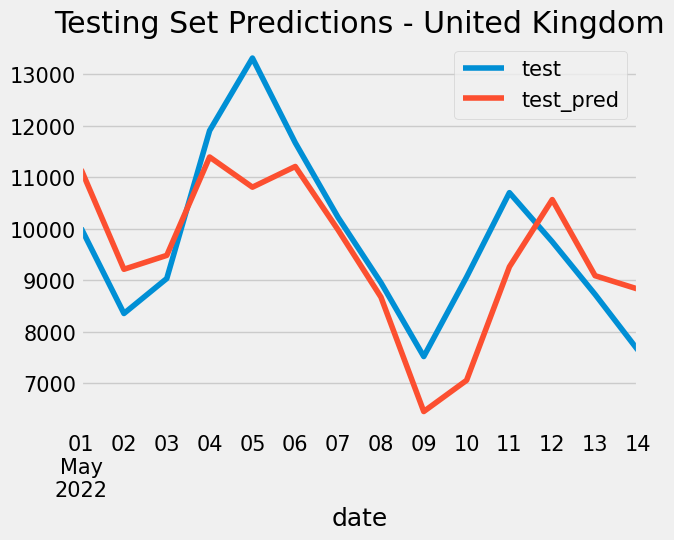

United Kingdom - Train RMSE: 2570.437138522382
United Kingdom - Test RMSE: 1152.8371332746378


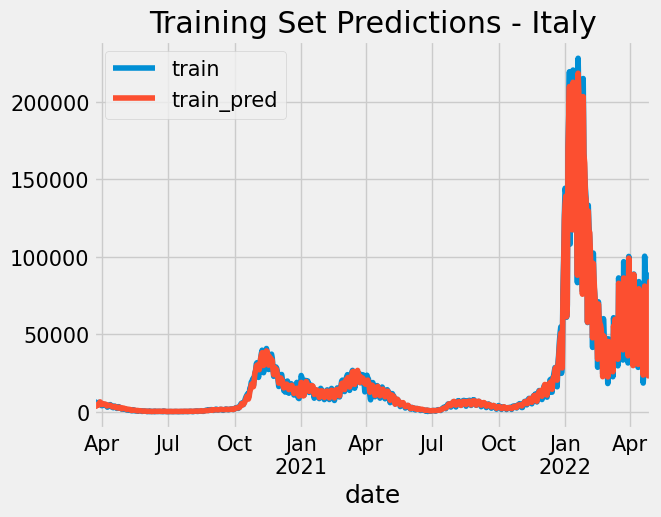

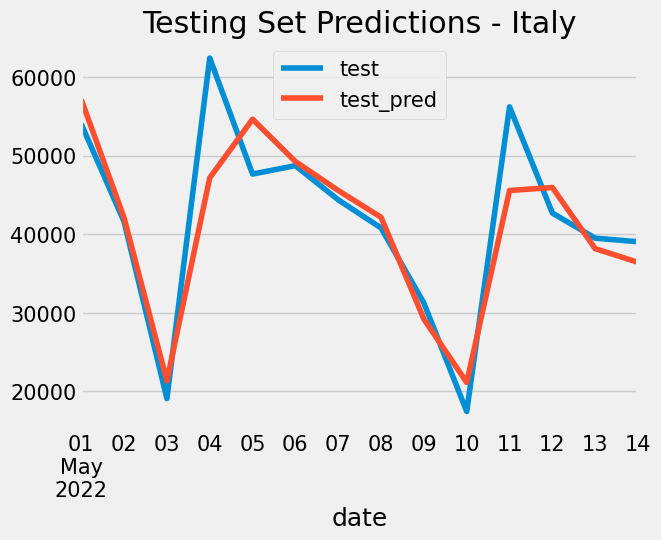

Italy - Train RMSE: 2342.8120075917423
Italy - Test RMSE: 5670.803434161197


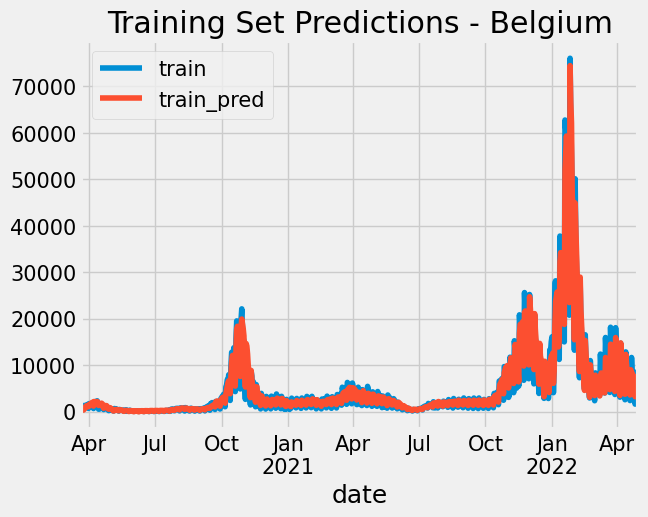

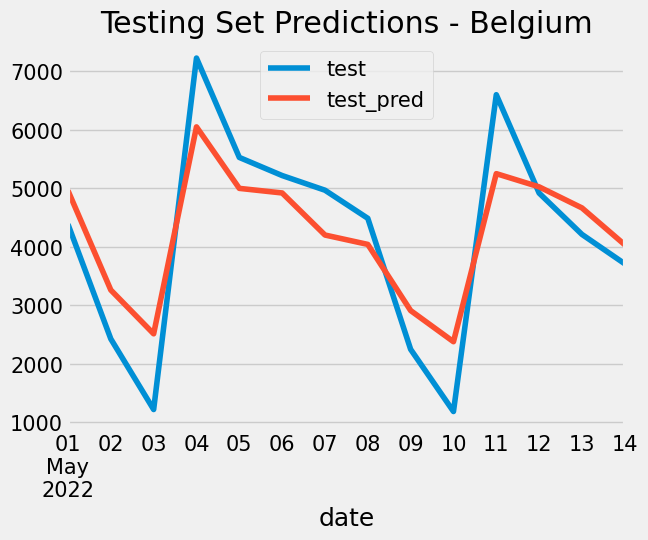

Belgium - Train RMSE: 1286.531174372057
Belgium - Test RMSE: 813.3978098151213


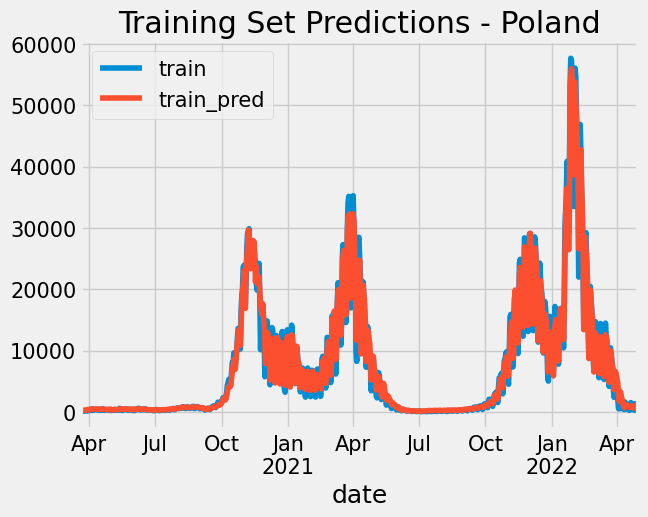

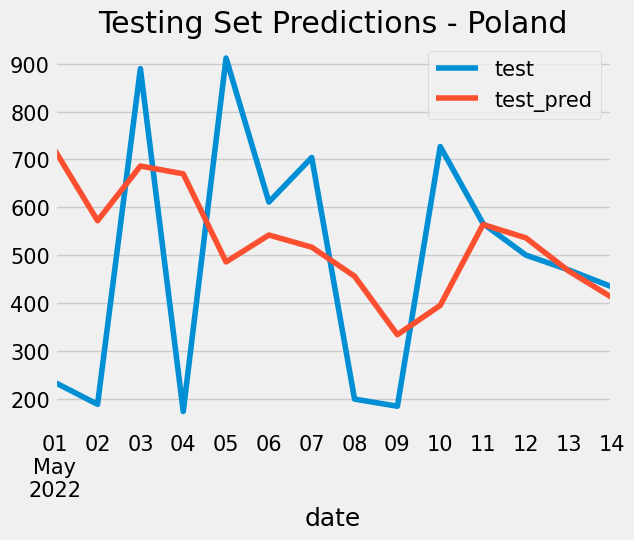

Poland - Train RMSE: 1231.5416446510292
Poland - Test RMSE: 279.5270513093959


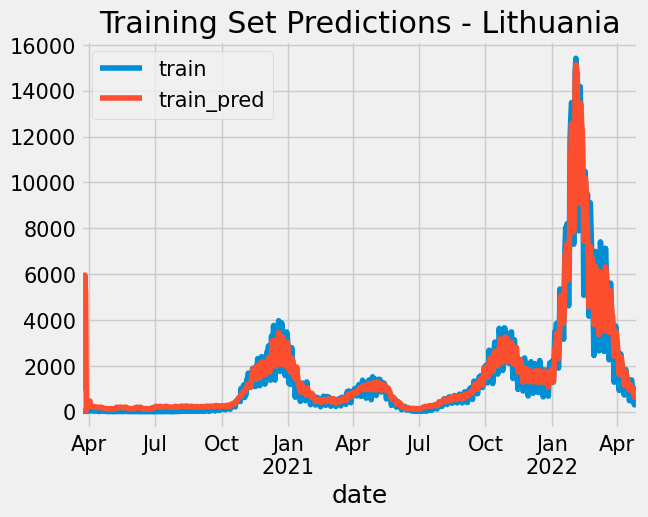

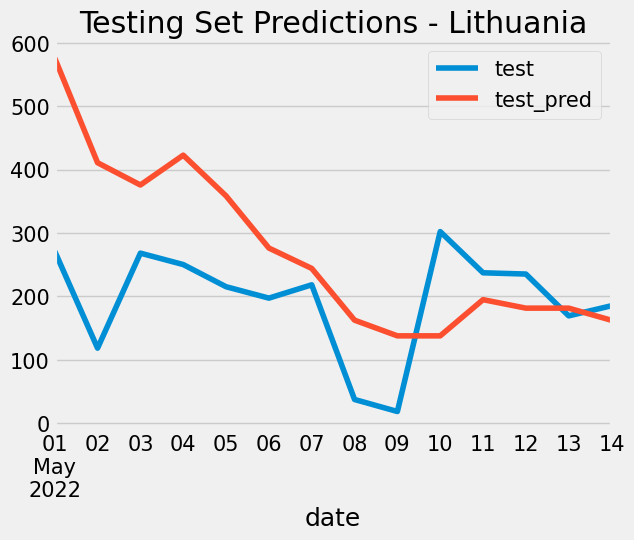

Lithuania - Train RMSE: 529.8001687366284
Lithuania - Test RMSE: 148.80722696507024


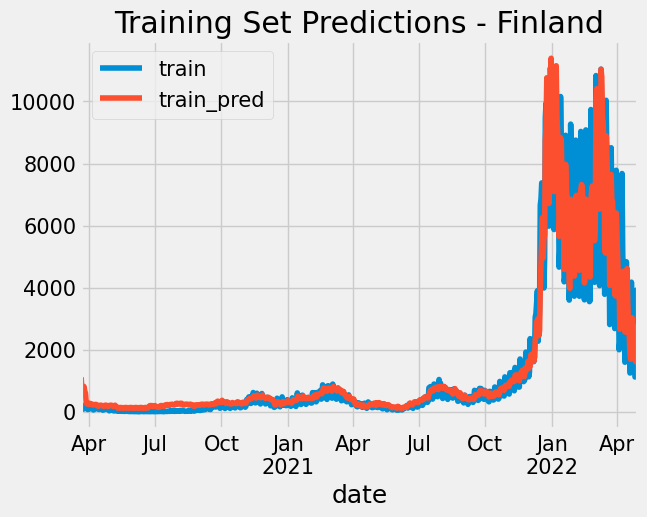

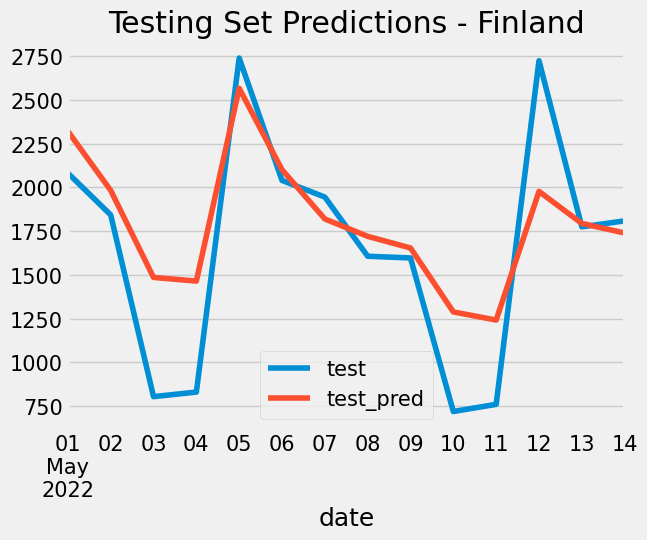

Finland - Train RMSE: 491.4418152111666
Finland - Test RMSE: 389.6803125976961


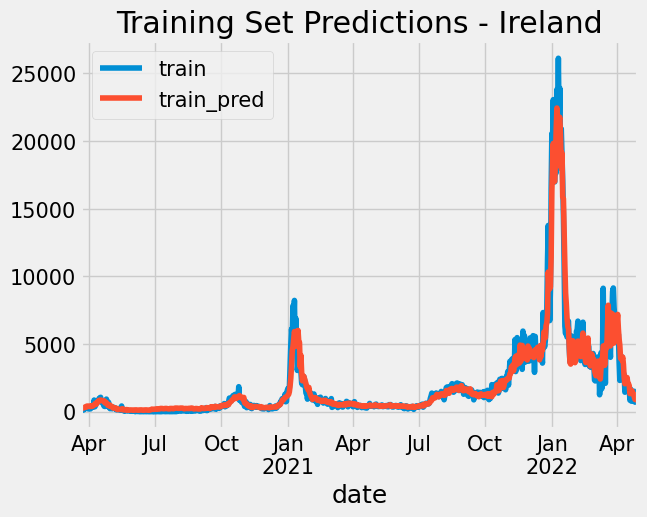

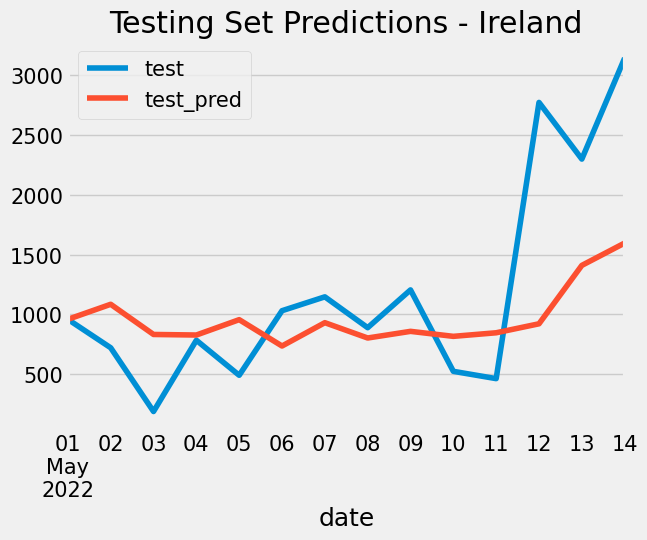

Ireland - Train RMSE: 726.465596668974
Ireland - Test RMSE: 749.809807723966


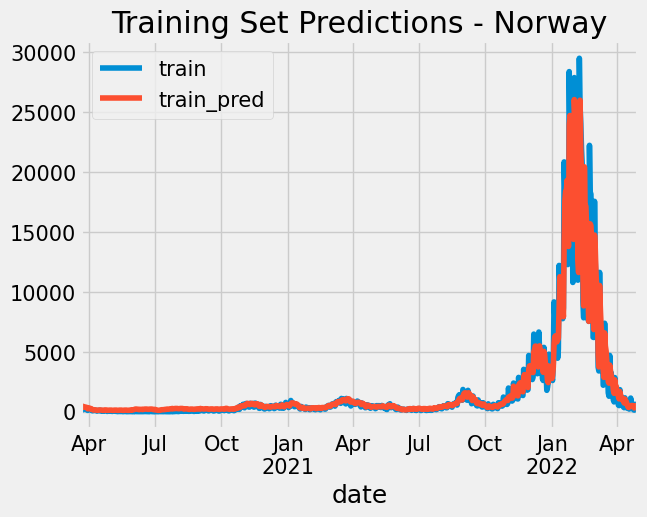

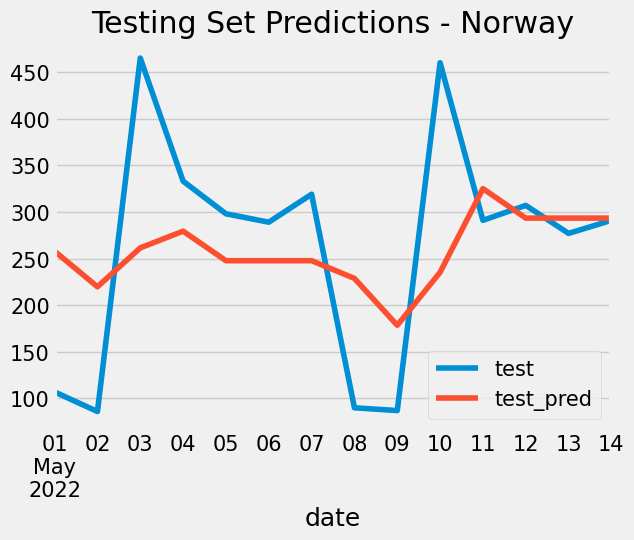

Norway - Train RMSE: 649.4816784857912
Norway - Test RMSE: 111.48836335620591


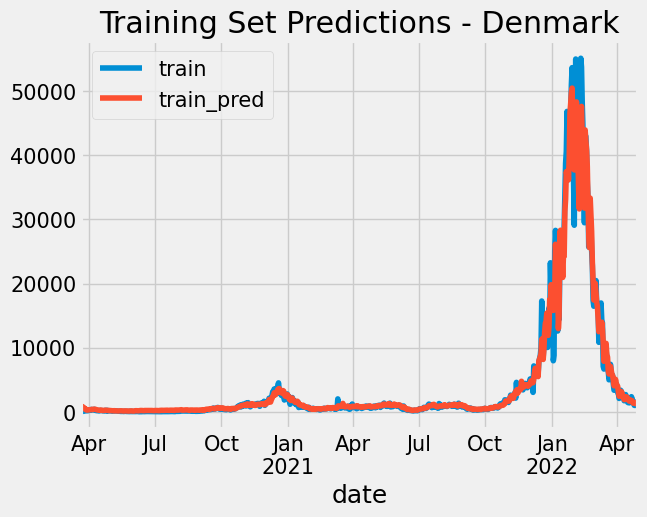

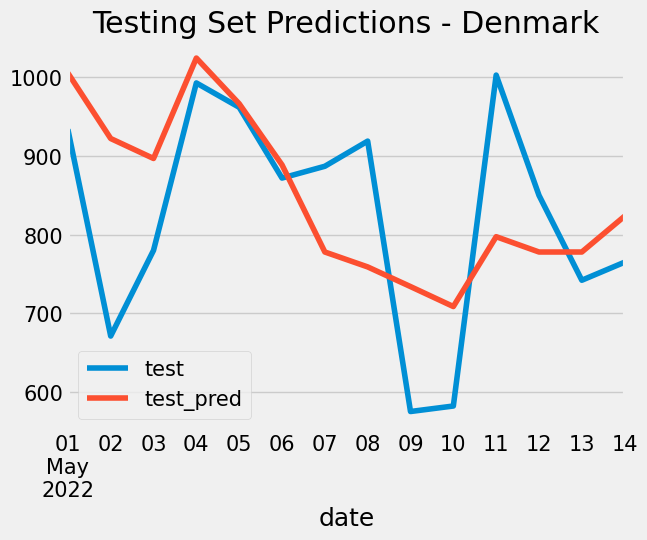

Denmark - Train RMSE: 1288.2569510071733
Denmark - Test RMSE: 123.70452463577384


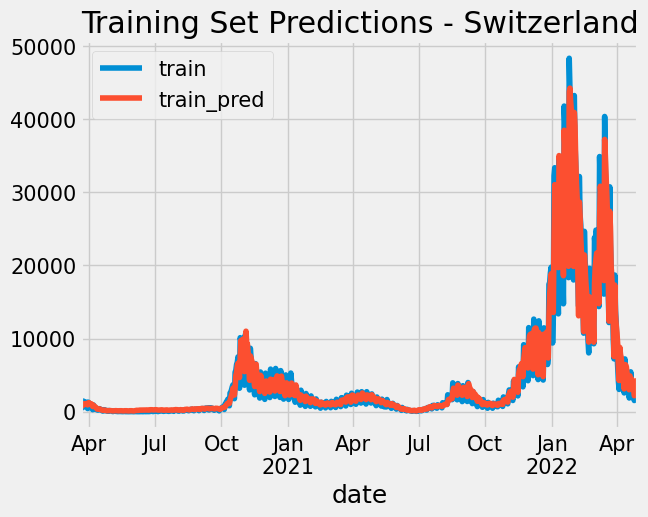

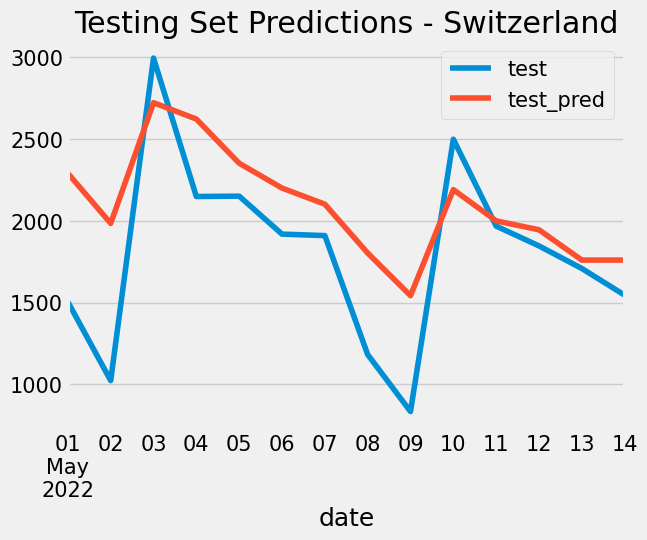

Switzerland - Train RMSE: 1065.0743098633766
Switzerland - Test RMSE: 465.665950796376
                 train_rmse    test_rmse
United Kingdom  2570.437139  1152.837133
Italy           2342.812008  5670.803434
Belgium         1286.531174   813.397810
Poland          1231.541645   279.527051
Lithuania        529.800169   148.807227
Finland          491.441815   389.680313
Ireland          726.465597   749.809808
Norway           649.481678   111.488363
Denmark         1288.256951   123.704525
Switzerland     1065.074310   465.665951


In [31]:
countries = ['United Kingdom', 'Italy', 'Belgium', 'Poland','Lithuania','Finland', 'Ireland', 'Norway', 'Denmark','Switzerland']
rmse_results = {}

for country in countries:
    location_column = f'location_{country}'

    # train set preds
    train_pred = pd.DataFrame(model4.predict(x_train), columns=['yhat'], index=train.index)
    train_combined = pd.concat([x_train, y_train, train_pred['yhat']], axis=1)
    subset_country_train = train_combined[train_combined[location_column] == 1]

    subset_country_train[['y', 'yhat']].plot()
    plt.title(f'Training Set Predictions - {country}')
    plt.legend(['train', 'train_pred'])
    plt.show()

    # test set preds
    test_pred = pd.DataFrame(model4.predict(x_test), columns=['yhat'], index=test.index)
    test_combined = pd.concat([x_test, y_test, test_pred['yhat']], axis=1)
    subset_country_test = test_combined[test_combined[location_column] == 1]

    subset_country_test[['y', 'yhat']].plot()
    plt.title(f'Testing Set Predictions - {country}')
    plt.legend(['test', 'test_pred'])
    plt.show()

    # Calculate and print RMSE for training and testing sets
    train_rmse = sqrt(mean_squared_error(subset_country_train['y'], subset_country_train['yhat']))
    test_rmse = sqrt(mean_squared_error(subset_country_test['y'], subset_country_test['yhat']))
    rmse_results[country] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}
    
    print(f'{country} - Train RMSE: {train_rmse}')
    print(f'{country} - Test RMSE: {test_rmse}')
    
rmse_df = pd.DataFrame(rmse_results).T
print(rmse_df)